# Drug Prescription Prediction
Sources: https://www.kaggle.com/datasets/rouzbeh/introds

## Step1. Data reading and Preprocessing 

In [11]:
from sklearn import svm
from sklearn import datasets
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from itertools import cycle

In [23]:
data = pd.read_csv('Drug.csv')
print(data)
print(data.info())
print(pd.isnull(data).sum())

     Age Sex      BP Cholesterol        Na         K   Drug
0     23   F    HIGH        HIGH  0.792535  0.031258  drugY
1     47   M     LOW        HIGH  0.739309  0.056468  drugC
2     47   M     LOW        HIGH  0.697269  0.068944  drugC
3     28   F  NORMAL        HIGH  0.563682  0.072289  drugX
4     61   F     LOW        HIGH  0.559294  0.030998  drugY
..   ...  ..     ...         ...       ...       ...    ...
195   56   F     LOW        HIGH  0.848774  0.073380  drugC
196   16   M     LOW        HIGH  0.743021  0.061886  drugC
197   52   M  NORMAL        HIGH  0.549945  0.055581  drugX
198   23   M  NORMAL      NORMAL  0.784520  0.055959  drugX
199   40   F     LOW      NORMAL  0.683503  0.060226  drugX

[200 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-

In [24]:
# Encoding variables (Sex, BP, Cholesterol, Drug)
en_sex = LabelEncoder()
en_bp = LabelEncoder()
en_chol = LabelEncoder()
en_drug = LabelEncoder()
data['Sex'] = en_sex.fit_transform(data['Sex'])
data['BP'] = en_bp.fit_transform(data['BP'])
data['Cholesterol'] = en_chol.fit_transform(data['Cholesterol'])
data['Drug'] = en_drug.fit_transform(data['Drug'])

# Defining features and target
X = data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na', 'K']]   # features
y = data['Drug']  #traget

## Step2. Splitting the dataset into training and testing sets

In [45]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [46]:
# scaling numerical features 
scaler = StandardScaler()
X_train[['Age', 'Na', 'K']] = scaler.fit_transform(X_train[['Age', 'Na', 'K']])
X_test[['Age', 'Na', 'K']] = scaler.transform(X_test[['Age', 'Na', 'K']])

## Step3. Model building and prediction 

In [47]:
# Initialaize the models 
# Logistic Regression
log_reg = LogisticRegression(solver='lbfgs', multi_class='auto')
# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)
# Support Vector Machines (SVM)
svm = SVC(probability=True, random_state=0)
# Ensemble/Voting Classification
voting_clf = VotingClassifier(estimators=[('lr', log_reg), ('knn', knn), ('svm', svm)], voting='soft')

In [49]:
# Training
models = {'Logistic Regression': log_reg, 'KNN': knn, 'SVM': svm, 'Voting Classifier': voting_clf}
accuracies = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[model_name] = accuracy

print(accuracies)

{'Logistic Regression': 0.9166666666666666, 'KNN': 0.8833333333333333, 'SVM': 0.9333333333333333, 'Voting Classifier': 0.9333333333333333}


C:\Users\crowu\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\crowu\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Step4. Model Evaluation 

<Figure size 1000x800 with 0 Axes>

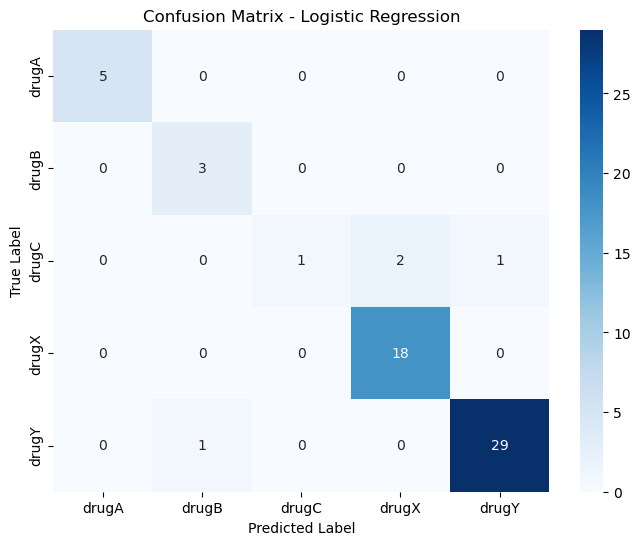

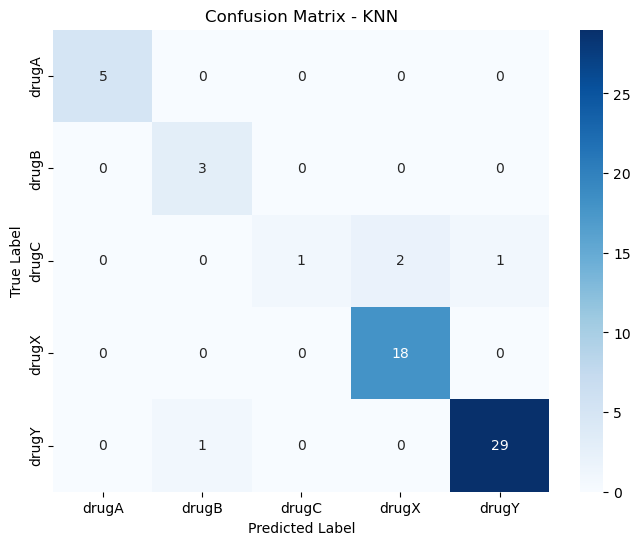

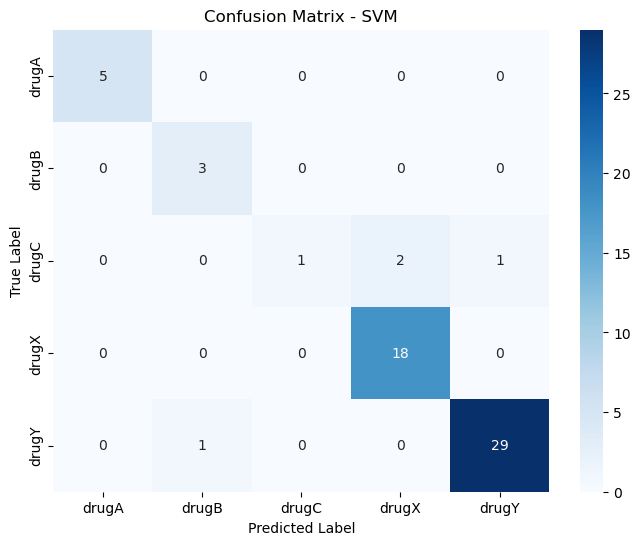

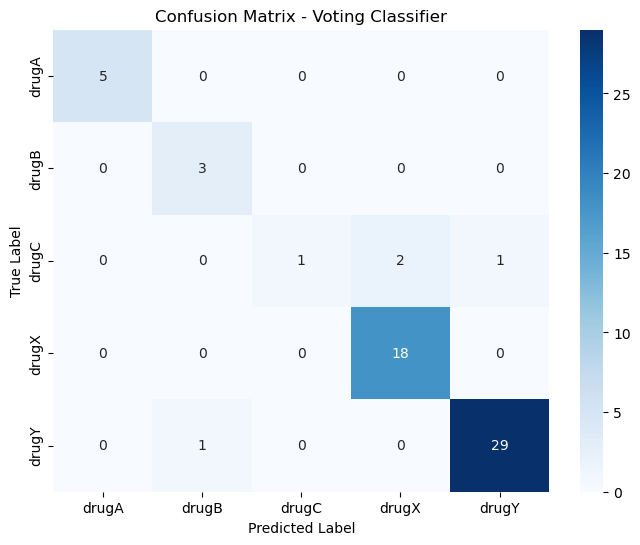

In [60]:
# Computing confusion matrix
plt.figure(figsize=(10, 8))
colors = cycle(['#0069BA', '#005B94', '#033045', '#041A21'])
results={}
for model_name, model in models.items():
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=en_drug.classes_, output_dict=True)
    results[model_name] = {'confusion_matrix': cm, 'report': report}
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=en_drug.classes_, yticklabels=en_drug.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.show()

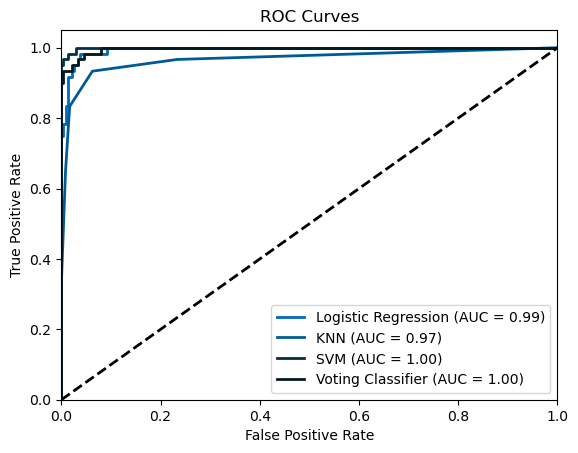

In [61]:
# computing ROC curve
for model_name, model, color in zip(models.keys(), models.values(), colors):
    # Computing micro-average ROC curve
    y_score = model.predict_proba(X_test)
    # Binarize the output for micro-averaging
    from sklearn.preprocessing import label_binarize
    y_test_bin = label_binarize(y_test, classes=np.arange(len(en_drug.classes_)))
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    # Plotting ROC curve
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{model_name} (AUC = {roc_auc:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.savefig('roc_curves_micro_average.png')
plt.show()

In [58]:
# Printing reports
for model_name, result in results.items():
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, models[model_name].predict(X_test), target_names=en_drug.classes_))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       drugA       0.71      1.00      0.83         5
       drugB       0.75      1.00      0.86         3
       drugC       1.00      0.25      0.40         4
       drugX       1.00      0.94      0.97        18
       drugY       0.94      0.97      0.95        30

    accuracy                           0.92        60
   macro avg       0.88      0.83      0.80        60
weighted avg       0.93      0.92      0.91        60


Classification Report for KNN:
              precision    recall  f1-score   support

       drugA       0.83      1.00      0.91         5
       drugB       0.67      0.67      0.67         3
       drugC       0.50      0.25      0.33         4
       drugX       0.89      0.89      0.89        18
       drugY       0.94      0.97      0.95        30

    accuracy                           0.88        60
   macro avg       0.76      0.75      0.75        